In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
# pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital_clean_unflatten.csv', check_param=True, na_values='empty')
pf.session.load_data(name='breast-cancer', src=FILE, fpath='breast-cancer-wisconsin/breast-cancer-wisconsin-enhanced-10-dirty.csv', check_param=True, na_values='empty')

INFO:profiler.utility:[2.460017204284668] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "0": "numeric",
    "1": "numeric",
    "2": "numeric",
    "3": "numeric",
    "4": "numeric",
    "5": "numeric",
    "6": "numeric",
    "7": "numeric",
    "8": "categorical",
    "9": "numeric",
    "10": "categorical"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'0': ['equal'], '1': ['equal'], '2': ['equal'], '3': ['equal'], '4': ['equal'], '5': ['equal'], '6': ['equal'], '7': ['equal'], '8': ['equal'], '9': ['equal'], '10': ['equal']}
INFO:profiler.data.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utili

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample','HospitalType','HospitalOwner', 'Condition'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC, TEXT,TEXT, TEXT],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients', None, None,None])

INFO:profiler.data.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.data.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.data.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.data.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.data.dataset:updated types of State to 'text'
INFO:profiler.data.dataset:updated operators of State to ['equal']
INFO:profiler.data.dataset:updated types of EmergencyService to 'text'
INFO:profiler.data.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.data.dataset:updated types of Score to 'numeric'
INFO:profiler.data.dataset:updated operators of Score to ['equal']
INFO:profiler.data.dataset:updated types of Sample to 'numeric'
INFO:profiler.data.dataset:updated operators of Sample to ['equal']
INFO:profiler.data.dataset:upd

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [4]:
pf.session.load_embedding(save=True, path='data/', load=False)

INFO:profiler.utility:[7.807249307632446] Load Embedding start

INFO:profiler.utility:[7.811892747879028] Load Embedding execution time: 0.004643440246582031



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [5]:
# use simple empirical cov: difference=False
# use difference -> cov : difference=True
pf.session.load_training_data(multiplier = None, difference=True)

INFO:profiler.utility:[10.717896223068237] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 1 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 1, and the bound is 0.00111575
INFO:profiler.data.transformer:Using multiplier 5
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 11/11 [00:00<00:00, 153.77it/s]
INFO:profiler.data.transformer:Number of training samples: 77000
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[11.141395330429077] Create Training Data execution time: 0.42349910736083984



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [6]:
# set sparsity to 0 for exp_reproduce 
autoregress_matrix = pf.session.learn_structure(sparsity=0, infer_order=True)

INFO:profiler.utility:[13.67332649230957] Learn Structure start

INFO:profiler.learner:use threshold 0.3018
INFO:profiler.utility:[13.897108554840088] Learn Structure execution time: 0.22378206253051758



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [7]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[16.76498794555664] Get Dependencies start

INFO:profiler.utility:[16.841519832611084] Get Dependencies execution time: 0.07653188705444336



1 -> 0 (0.21823330109898093)
1 -> 2 (0.120935945309838)
0,2 -> 3 (0.003623885410185783)
0,2,3 -> 5 (0.05617785270965386)
1,0,3,5 -> 6 (0.13551095465309373)
1,0,3,5 -> 7 (0.10115485721364421)
1,0,3,6,7 -> 8 (0.5119392423783516)
1,0,7,8 -> 9 (0.08084290814265076)
0,2,3,6,8,9 -> 10 (0.08901097813368064)
1,3,5,6,7,8,10 -> 4 (0.12085381129959323)
{'1': array([], dtype=object), '0': array(['1'], dtype=object), '2': array(['1'], dtype=object), '3': array(['0', '2'], dtype=object), '5': array(['0', '2', '3'], dtype=object), '6': array(['1', '0', '3', '5'], dtype=object), '7': array(['1', '0', '3', '5'], dtype=object), '8': array(['1', '0', '3', '6', '7'], dtype=object), '9': array(['1', '0', '7', '8'], dtype=object), '10': array(['0', '2', '3', '6', '8', '9'], dtype=object), '4': array(['1', '3', '5', '6', '7', '8', '10'], dtype=object)}


In [9]:
import os, json
def read_fds(path='data/fds', f='TECHospital-hyfd'):
    all_fds = {}
    for line in open(os.path.join(path,f)):
        fd = json.loads(line)
        right = fd[u'dependant']['columnIdentifier']
        left = [l[u'columnIdentifier'] for l in fd[ u'determinant'][u'columnIdentifiers']]
        if right not in all_fds:
            all_fds[right] = set()
        all_fds[right].add(frozenset(left))
    return all_fds

In [10]:
gt = read_fds(f='hospital_clean-fun')

In [11]:
tp = 0
count = 0
for child in parent_sets:
    found = parent_sets[child]
    if len(found) == 0:
        continue
    count += 1
    match = False
    for parent in gt[child]:
        if set(parent).issubset(found):
            tp += 1
            match = True
            break
    if not match:
        print("{} -> {} is not valid".format(found, child))
if count > 0:
    print("Precision: %.4f"%(float(tp) / count))

['HospitalOwner'] -> ZipCode is not valid
['HospitalType' 'State'] -> Stateavg is not valid
['ZipCode' 'State' 'MeasureName'] -> Sample is not valid
['HospitalType' 'Stateavg'] -> Score is not valid
Precision: 0.7500


## 5. Visualization

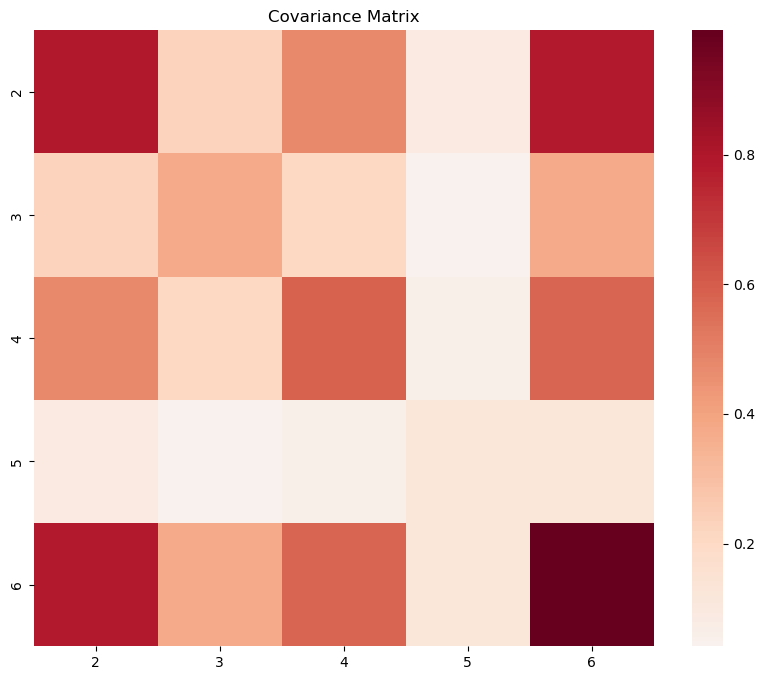

In [15]:
pf.session.visualize_covariance()

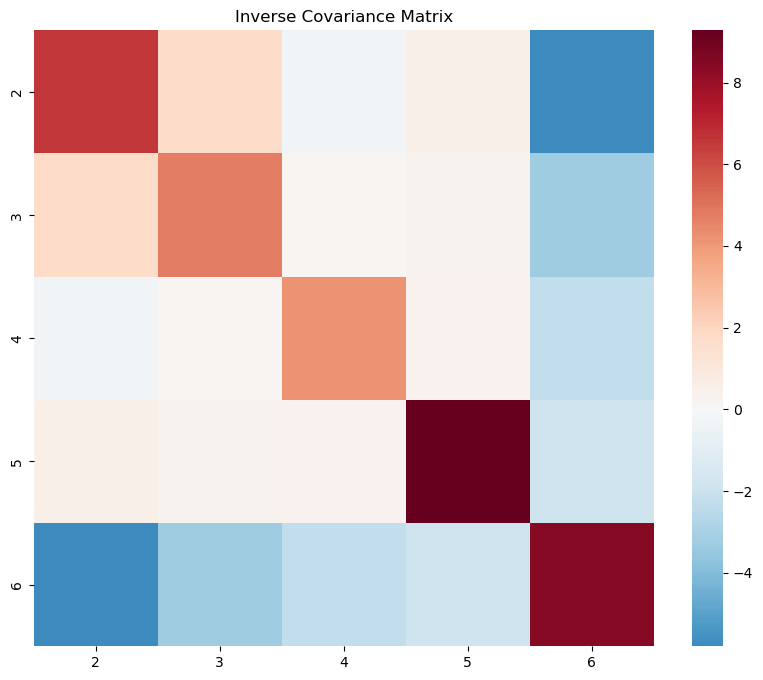

In [16]:
pf.session.visualize_inverse_covariance()

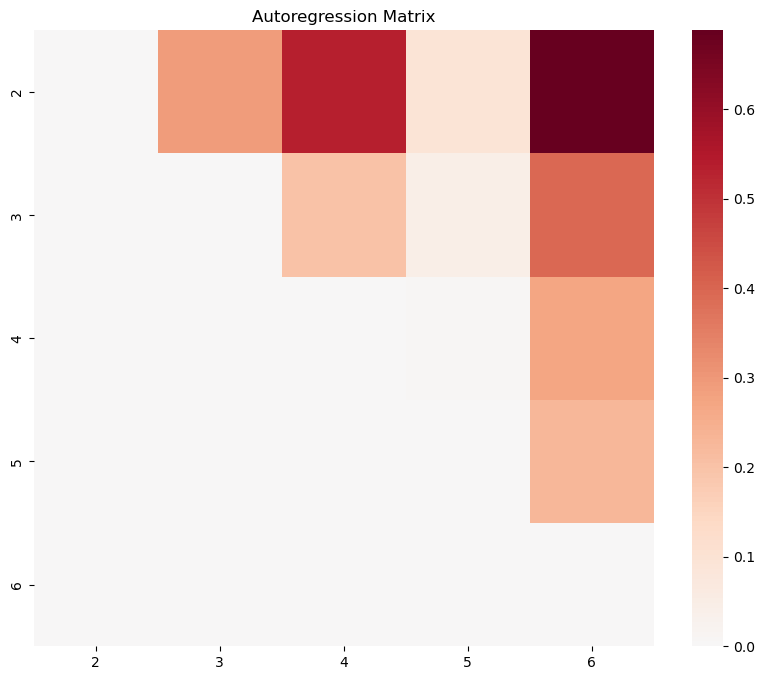

In [17]:
pf.session.visualize_autoregression()

In [8]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,2.460017,start: Load Data,0.000000
1,2.573404,end: Load Data,0.113386
2,7.807249,start: Load Embedding,0.000000
3,7.811893,end: Load Embedding,0.004643
4,10.717896,start: Create Training Data,0.000000
5,11.141395,end: Create Training Data,0.423499
6,13.673326,start: Learn Structure,0.000000
7,13.897109,end: Learn Structure,0.223782
8,16.764988,start: Get Dependencies,0.000000
9,16.841520,end: Get Dependencies,0.076532


In [16]:
pf.session.timer.to_csv()